In [1]:
import os
import wfdb
import numpy as np

def load_mitbih_dataset(path):
    # Define annotation list
    annots_list = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']

    # This will hold the signal segments corresponding to beats
    X = []
    # This will hold the binary labels corresponding to each beat
    y = []

    # Get the list of record names from the 'RECORDS' file
    record_list = []
    with open(os.path.join(path, 'RECORDS'), 'r') as file:
        record_list = [line.strip() for line in file]

    # Process each record
    for record_name in record_list:
        # Load the record and its annotation
        record = wfdb.rdrecord(os.path.join(path, record_name))
        annotation = wfdb.rdann(os.path.join(path, record_name), 'atr')

        # Get the signal and annotation values
        signal = record.p_signal[:, 0]  # assuming you only want the first signal
        beat_annotations = annotation.symbol
        beat_locations = annotation.sample

        # Iterate over each beat annotation
        for sym, loc in zip(beat_annotations, beat_locations):
            # Check if the annotation symbol is in the classes of interest
            if sym in annots_list:
                # Binary classification: normal (0) vs abnormal (1)
                label = 0 if sym == 'N' else 1
                
                # Define a window size around each beat
                win_size = 625  # This gives a window of 1250 samples around the beat
                # Avoid going out of bounds
                if loc - win_size >= 0 and loc + win_size <= len(signal):
                    # Extract the segment and append to the list
                    segment = signal[loc - win_size: loc + win_size]
                    X.append(segment)
                    y.append(label)

    # Convert lists to numpy arrays for ML processing
    X = np.array(X)
    y = np.array(y)

    return X, y


In [3]:
#run this step just onceeeeeeeeee, next time just load from the saved train test
# import numpy as np
# from sklearn.model_selection import train_test_split

# # Load your dataset
# X, y = load_mitbih_dataset("/home/researchgroup/mahjabeen_workspace/research/CLINet-ECG-Classification-2024/data/mit-bih/mitbih_database/")

# # Step 1: Perform the split once
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# # Step 2: Save the split data to disk
# np.save('./X_train.npy', X_train)
# np.save('./X_test.npy', X_test)
# np.save('./y_train.npy', y_train)
# np.save('./y_test.npy', y_test)

# # In future sessions, you can load the datasets directly from the saved files:
# X_train = np.load('./X_train.npy')
# X_test = np.load('./X_test.npy')
# y_train = np.load('./y_train.npy')
# y_test = np.load('./y_test.npy')

# # Use X_train, X_test, y_train, y_test for model training and evaluations


In [4]:
!ls -l *.npy


-rw-rw-r-- 1 researchgroup researchgroup 218580128 Apr  4 13:16 X_test.npy
-rw-rw-r-- 1 researchgroup researchgroup 874290128 Apr  4 13:16 X_train.npy
-rw-rw-r-- 1 researchgroup researchgroup    174992 Apr  4 13:16 y_test.npy
-rw-rw-r-- 1 researchgroup researchgroup    699560 Apr  4 13:16 y_train.npy


In [2]:
# Loading the Saved Train-Test Split
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, TimeDistributed, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc

# Load the saved datasets
X_train = np.load('./X_train.npy')
X_test = np.load('./X_test.npy')
y_train = np.load('./y_train.npy')
y_test = np.load('./y_test.npy')


2024-04-07 16:05:04.541467: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-07 16:05:04.579243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 16:05:05.254641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#Defining my Model
#network.py
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, TimeDistributed, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_lstm_model(input_shape=(1250, 1)):
    # No need to pass num_classes for binary classification
    inputs = keras.layers.Input(shape=input_shape)

    # Convolutional layers
    x11 = Conv1D(filters=3, kernel_size=31, strides=5, padding='same', activation=None, use_bias=True)(inputs)
    x12 = Conv1D(filters=3, kernel_size=36, strides=5, padding='same', activation=None, use_bias=True)(inputs)
    x13 = Conv1D(filters=3, kernel_size=41, strides=5, padding='same', activation=None, use_bias=True)(inputs)
    conv = keras.layers.concatenate([x11, x12, x13], axis=-1)

    # Batch normalization and ReLU activation
    x = BatchNormalization()(conv)
    x = ReLU()(x)

    # LSTM layer
    x = TimeDistributed(Flatten())(x)
    x = LSTM(200, return_sequences=False)(x)  # Adjust return_sequences based on whether you're adding more LSTM layers or not

    # Dense layers for classification
    x = Dropout(0.3)(x)
    x = Dense(20, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(10, activation='relu')(x)
    
    # Adjusted for binary classification: single output neuron, sigmoid activation
    outputs = Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=[outputs], name="lstm_model")
    
    # Compile the model with binary crossentropy loss and include 'Precision' and 'Recall' in metrics
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall'])

    return model


In [7]:
import os
import re

# Path to the directory where checkpoints are saved
checkpoint_dir = './model_checkpoint.keras'

# List all files in the checkpoint directory
checkpoint_files = os.listdir(checkpoint_dir)

# Regular expression to extract the epoch number from the filename
epoch_regex = r"_epoch_(\d+)_"

# Initialize a list to store the epoch numbers
epochs = []

# Iterate over the checkpoint filenames
for filename in checkpoint_files:
    match = re.search(epoch_regex, filename)
    if match:
        # Extract the epoch number and convert it to an integer
        epoch_num = int(match.group(1))
        epochs.append(epoch_num)

# Find the maximum epoch number (last saved epoch)
if epochs:
    last_saved_epoch = max(epochs)
    print(f"The last saved epoch was: {last_saved_epoch}")
else:
    print("No checkpoints found.")


NotADirectoryError: [Errno 20] Not a directory: './model_checkpoint.keras'

In [6]:
#Compiling and Training the Model
import os
from tensorflow import keras

# Calculate class weights for balancing the training
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Check if a checkpoint exists
checkpoint_path = './model_checkpoint.keras'
if os.path.exists(checkpoint_path):
    print("Loading previously saved model...")
    model = keras.models.load_model(checkpoint_path)
    # Manually set the initial_epoch parameter based on how many epochs were previously run
    initial_epoch = 50  # Adjust this based on your last saved epoch
else:
    print("No checkpoint found. Initializing a new model...")
    model = create_lstm_model(input_shape=(1250, 1))
    initial_epoch = 0

# Continue with the compilation, setup your callbacks and start training
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Consider setting this to False if you want to save after every epoch regardless of performance
    monitor='val_accuracy',
    mode='max',
    verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # Total number of epochs you aim to train
    initial_epoch=initial_epoch,  # Start from the epoch after the last saved one
    batch_size=32,
    callbacks=[model_checkpoint_callback],
    class_weight=class_weight_dict)

# Optionally, save the final model
final_model_path = 'final_model.keras'
model.save(final_model_path)
print(f"Model saved to {final_model_path}")
print(history.history.keys())


Loading previously saved model...
Model saved to final_model.keras
dict_keys([])


In [5]:
from tensorflow.keras.models import load_model

model = load_model('./final_model.keras')


/home/researchgroup/mahjabeen_workspace/research/clinet-env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 36 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [4]:
#Evaluating the Model on Test Data
eval_results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {eval_results[0]}")
print(f"Test Accuracy: {eval_results[1]}")


684/684 ━━━━━━━━━━━━━━━━━━━━ 77s 110ms/step - Precision: 0.9882 - Recall: 0.9919 - accuracy: 0.9938 - loss: 0.0199
Test Loss: 0.020192107185721397
Test Accuracy: 0.9865314960479736


In [7]:
#Generating Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.round(y_pred_probs).astype(int)  # Assuming a binary classification
print(y_pred[:10])


684/684 ━━━━━━━━━━━━━━━━━━━━ 71s 104ms/step
[[0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]]


In [8]:
#Generating and Printing the Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Normal', 'Abnormal']))


              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     14995
    Abnormal       0.99      0.99      0.99      6863

    accuracy                           0.99     21858
   macro avg       0.99      0.99      0.99     21858
weighted avg       0.99      0.99      0.99     21858



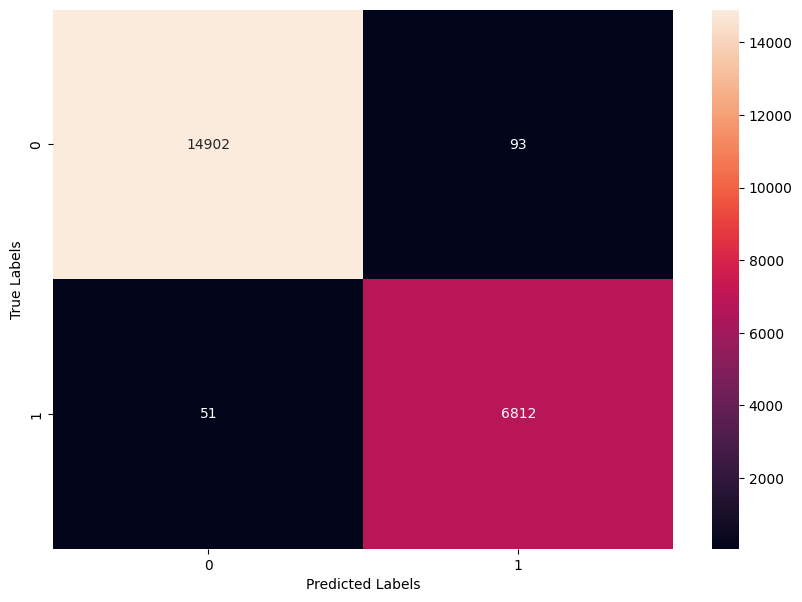

In [9]:
#Plotting the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [10]:
#Plotting Learning Curves (Loss vs Epoch)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

KeyError: 'accuracy'

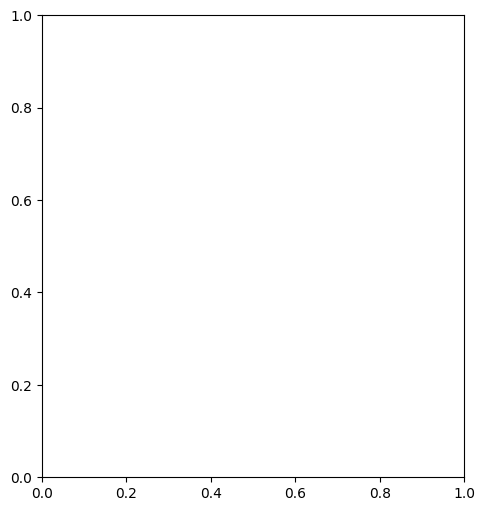

In [12]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [13]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

time_callback = TimeHistory()
model.fit(X_train, y_train, ..., callbacks=[time_callback])

# Sum the times for total training time
total_time = sum(time_callback.times)
print(f"Total training time: {total_time}s")


TypeError: unsupported operand type(s) for /: 'int' and 'ellipsis'